# German Electricity Data :electric_plug: 

- Data Source: [SMARD Web Portal](https://www.smard.de/) 
- Task: forecasting (using the past to predict the future)
- Language: [julia](https://julialang.org)

## First steps:

- load the data \(with appropriate column types\) :heavy_check_mark: 
- split the data into train/val/test sets
- plot the time series \(at different temporal resolution\)
- calculate the mean production per month
- is there a seasonal pattern \(what kinds of seasonalities\)
- make a prediction for the validation set
- evaluate the quality of the prediction



In [3]:
ENV["COLUMNS"] = 1000; # print more columns of tables

In [4]:
using Random

In [5]:
Random.seed!(42)
"Andi Kerstin Chris Caro Jana" |> split |> shuffle |> x -> join(x," → ")

"Andi → Chris → Caro → Kerstin → Jana"

## 1. Data loading

- load the hourly data from the file `Realisierte_Erzeugung_201501010000_202305301300_Stunde.csv` as a table into julia :heavy_check_mark:
- make sure, that data is interpreted and typed correctly :heavy_check_mark:
- clean header names :heavy_check_mark:
- create column `Time` containing the combined info from `Datum` and `Anfang`  



In [6]:
using Dates
using CSV
using DataFrames
using DataFramesMeta
using Chain
using CairoMakie

In [7]:
df = CSV.read("../data_dojo_22/Realisierte_Erzeugung_201501010000_202305301300_Stunde.csv",
    DataFrame,
    delim=";",
    decimal=',',
    groupmark='.',
    missingstring="-",
    dateformat=Dict("Datum"=>"dd.mm.yyyy"),
    types=Dict("Datum"=>Date)
);

In [8]:
clean_colname(x) = replace(split(x, " [")[1], " " => "_")
clean_names = clean_colname.(names(df));

In [9]:
rename!(df, clean_names)

Row,Datum,Anfang,Ende,Biomasse,Wasserkraft,Wind_Offshore,Wind_Onshore,Photovoltaik,Sonstige_Erneuerbare,Kernenergie,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige_Konventionelle
,Date,Time,Time,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?
1,2015-01-01,00:00:00,01:00:00,4024.25,1158.25,516.5,8128.0,0.0,133.0,10710.5,15687.2,3219.75,1226.25,1525.75,4909.25
2,2015-01-01,01:00:00,02:00:00,3982.75,1188.0,516.25,8297.5,0.0,122.5,11086.2,15321.8,2351.25,870.75,1079.25,4932.75
3,2015-01-01,02:00:00,03:00:00,4019.5,1139.25,514.0,8540.0,0.0,93.0,11026.2,14817.5,2227.0,809.5,787.0,5041.75
4,2015-01-01,03:00:00,04:00:00,4040.75,1122.5,517.75,8552.0,0.0,86.5,11027.8,14075.0,2339.75,821.0,287.75,5084.0
5,2015-01-01,04:00:00,05:00:00,4037.75,1112.0,519.75,8643.5,0.0,86.5,10962.2,14115.0,2461.5,831.25,346.75,5070.75
6,2015-01-01,05:00:00,06:00:00,4028.25,1107.75,520.0,8711.75,0.0,86.75,10696.0,13474.2,2217.75,851.0,765.5,5096.75
7,2015-01-01,06:00:00,07:00:00,4013.25,1111.75,521.5,9167.25,0.0,87.0,10299.5,12403.8,2373.25,868.25,414.5,5153.0
8,2015-01-01,07:00:00,08:00:00,4012.75,1113.75,520.25,9811.0,0.0,87.0,10035.2,12062.5,2491.0,876.0,582.5,5161.0
9,2015-01-01,08:00:00,09:00:00,3999.75,1107.5,525.25,9683.0,53.0,87.0,10245.8,12405.0,2530.25,888.25,750.5,5393.5


### Todo 2<sup>nd</sup> session
- Create `Time` column
- Split into training/validation/test set
- Plot the training set with hourly resolution
- Aggregate by day/month
- Plot aggregated data

<details>
    <summary>Bonus task</summary>
    <ul>
        <li>did you observe something peculiar with dates and times?</li>
        <li>look at the hourly data of 2017-10-29 for an example</li>
        <li>what happened there?</li>
        <li>are there more days with a similar "problem"?</li>
        <li>is this a problem?</li>
        <li>how can we solve this?</li>
    </ul>
</details>

In [10]:
datetime_vec = Dates.DateTime.(df.Datum, df.Anfang);
datetime_data = insertcols!(df,1, :Datetime => datetime_vec );
datetime_clean = select(datetime_data, Not([:Datum, :Anfang, :Ende]));

In [11]:
train = filter(:Datetime => <(Dates.Date(2021)), datetime_clean);
val = filter(:Datetime => d -> Dates.year(d)==2021, datetime_clean);
test = filter(:Datetime => >(Dates.Date(2021)), datetime_clean);

In [12]:
size(train), size(val), size(test)

((52608, 13), (8760, 13), (21107, 13))

In [13]:
data_y = @chain train begin
    @transform(:Year = Dates.year.(:Datetime))
    groupby(:Year)
    @combine(:Biomasse = sum(:Biomasse), :Wasserkraft = sum(:Wasserkraft), :Wind_Offshore = sum(:Wind_Offshore), :Wind_Onshore = sum(:Wind_Onshore), :Photovoltaik = sum(:Photovoltaik), :Sonstige_Erneuerbare = sum(:Sonstige_Erneuerbare), :Kernenergie = sum(:Kernenergie), :Braunkohle = sum(:Braunkohle) ,:Steinkohle = sum(:Steinkohle), :Erdgas = sum(:Erdgas), :Pumpspeicher = sum(:Pumpspeicher), :Sonstige_Konventionelle = sum(:Sonstige_Konventionelle))
end

Row,Year,Biomasse,Wasserkraft,Wind_Offshore,Wind_Onshore,Photovoltaik,Sonstige_Erneuerbare,Kernenergie,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige_Konventionelle
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2015,3.48479e7,1.37193e7,8.13438e6,6.90421e7,3.48794e7,9.4563e5,8.43635e7,1.33798e8,8.11387e7,1.52259e7,9.93722e6,5.29686e7
2,2016,3.97455e7,1.80759e7,1.20931e7,6.52747e7,3.45389e7,1.40346e6,8.02425e7,1.30376e8,8.089e7,2.28888e7,8.58761e6,4.73436e7
3,2017,4.03284e7,1.55901e7,1.74142e7,8.51901e7,3.58832e7,1.75439e6,7.2214e7,1.29287e8,6.60055e7,2.55804e7,9.29078e6,4.87431e7
4,2018,4.00905e7,1.52577e7,1.90684e7,8.92706e7,4.12343e7,1.53113e6,7.18417e7,1.28362e8,7.15453e7,4.28782e7,9.13598e6,1.2838e7
5,2019,4.03876e7,1.58305e7,2.43828e7,9.98789e7,4.19148e7,1.46438e6,7.10422e7,1.02729e8,4.78153e7,5.46197e7,9.02058e6,1.27306e7
6,2020,4.08223e7,1.55834e7,2.68832e7,1.03104e8,4.58216e7,1.60774e6,6.09239e7,8.3374e7,3.4872e7,5.9126e7,1.15287e7,1.29299e7


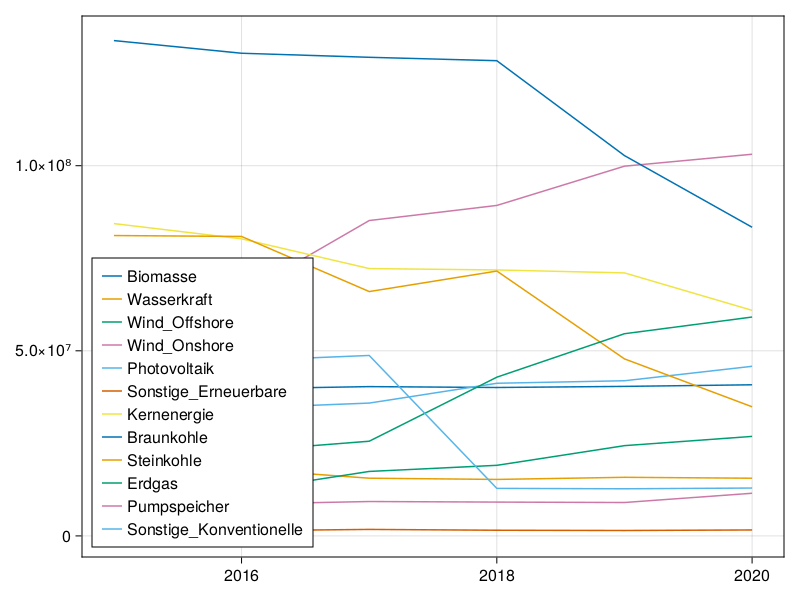

In [14]:
fig1 =lines(data_y.Year, data_y.Biomasse, label = "Biomasse")
for i in names(data_y)[3:end]
    lines!(fig1.axis, data_y.Year, data_y[!,i], label =i)
end
axislegend(fig1.axis, position = :lb)
fig1


### Todos 3<sup>rd</sup> Session

- Select one of the types (e.g. Photovoltaik, Erdgas or Wind_Onshore)
- What kinds of seasonality are detectable?
- Is there a general trend on top of the seasonal pattern(s)?
- Can you use this information to manually craft a prediction model?

Bonus:
- How accurately does your manually created model predict the values in the validation set?